In [1]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from numpy.linalg import pinv

# Clean Tensor from Separate Data
Using Tensor constructed from separate data without anomaly injections

In [2]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


Text(0, 0.5, 'Frequency')

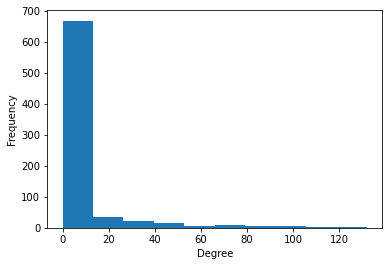

In [3]:
plt.hist(nx.degree_histogram(G))
plt.xlabel('Degree')
plt.ylabel('Frequency')

In [4]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [5]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [6]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [7]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [11]:
with open('../bc_tkd_r10.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()

In [13]:
factors = result

In [14]:
A, B, C = factors

In [17]:
A, B, C, = np.array(A)[:1000], np.array(B)[:1000], np.array(C)[:1000]

In [12]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [13]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [14]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [15]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [16]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

151.99378506962825 5.922384155613057
28.182793853936584 3.138077086574925


In [17]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

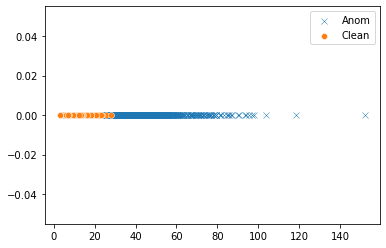

In [18]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

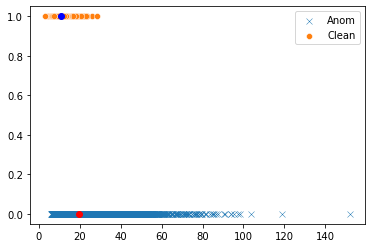

In [20]:
sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 1, c='blue')

plt.legend(['Anom', 'Clean'])

In [ ]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]

In [ ]:
plt.boxplot(comb)

In [ ]:
# using non-anomolous nodes from original data (no anomalies)

with open('egonets.sav', 'rb') as f:
    ego_gs = pickle.load(f)
    f.close()

print(f'Using {len(ego_gs)} egonets')

In [ ]:
indices = np.random.randint(0, len(anom_gs), size=len(clean_gs))

sampled_anoms = np.array(anom_gs, dtype=object)[indices]

In [ ]:
padded_anom = []
for gs in tqdm(sampled_anoms):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

In [ ]:
results_anom = []
indices = np.random.randint(0, len(padded_anom), size=len(padded_clean))
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
anom_y = np.zeros(len(results_anom))

In [ ]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

## Redefine Anomalies
Redefining anomalies egonets as egonets with root node as anomalous

In [3]:
bc_data = scipy.io.loadmat("../datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [4]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

In [5]:
G, ego_gs, _, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [6]:
roots = [int(r) for r in roots]

In [7]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [8]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [9]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [18]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/298 [00:00<?, ?it/s]

In [19]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4898 [00:00<?, ?it/s]

In [20]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

/home/zqazi004/anaconda3/envs/anom_detect/lib/python3.9/site-packages/seaborn/relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


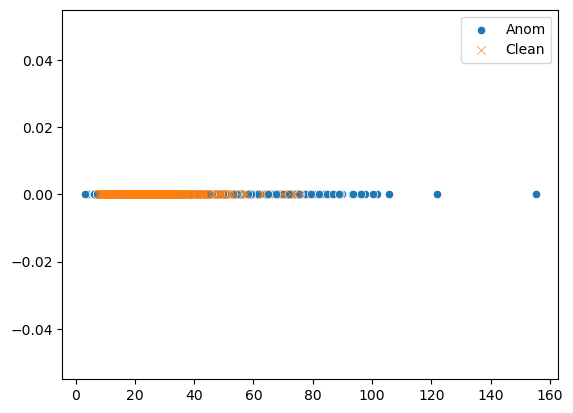

In [21]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

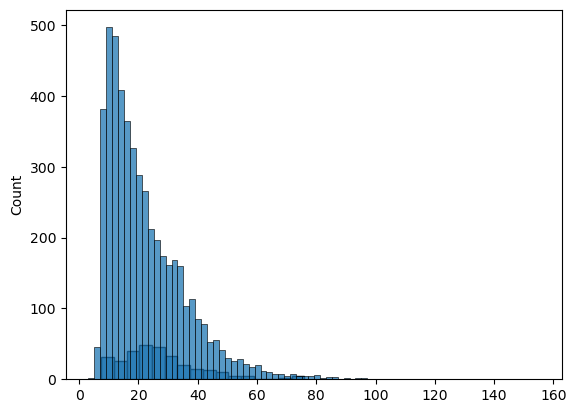

In [22]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [ ]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# Clean tensor with modified data
Using "clean" tensor from redefined clean egonets. 

See BC_EgoNet_Tensor.ipynb for details. 

In [5]:
with open('bc_decomp_r10.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

## Original Anomaly Definition

In [6]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [7]:
def load_bc_data(G):

    # G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    # G = nx.convert_node_labels_to_integers(G)
    ego_gs = []

    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
            if max_graph < G_ego.number_of_nodes():
                max_graph = G_ego.number_of_nodes()

    return G, ego_gs, max_graph

In [8]:
G, ego_gs, _ = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [9]:
# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [11]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [12]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [13]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/476 [00:00<?, ?it/s]

In [14]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

In [15]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/476 [00:00<?, ?it/s]

In [32]:
# storing results
saved_model = open('rec_error_clean.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [33]:
print(max(results_anom), min(results_anom))
print(max(results_clean), min(results_clean))

150.97796461553804 4.725902221549903
29.628322688595038 3.0777879545964697


In [209]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

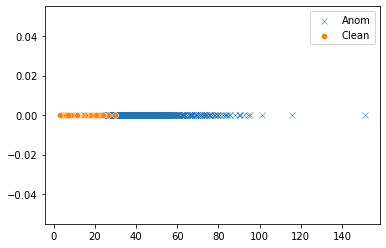

In [211]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

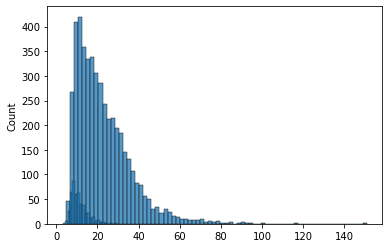

In [18]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb59c532d00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb59c52a3a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb59c540910>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb59c52a880>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb59c52ab50>,
 'means': []}

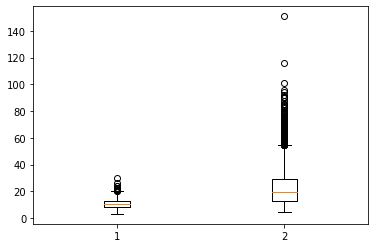

In [19]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [183]:
with open('rec_error_clean.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [184]:
sum(results_anom <= max(results_clean)) / len(results_anom)

0.7519067796610169

In [185]:
results, true_labels = [], []
results.extend(results_clean); results.extend(results_anom)
true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))

In [186]:
results = np.array(results).reshape(-1, 1)

In [187]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

<AxesSubplot:>

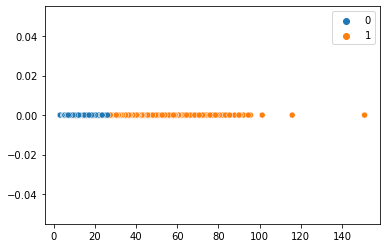

In [60]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)

In [63]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(kmeans.labels_, return_counts=True))

print(classification_report(true_labels, kmeans.labels_))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1], dtype=int32), array([3729, 1467]))
              precision    recall  f1-score   support

           0       0.13      1.00      0.23       476
           1       1.00      0.31      0.47      4720

    accuracy                           0.37      5196
   macro avg       0.56      0.65      0.35      5196
weighted avg       0.92      0.37      0.45      5196



## One Class K-means

In [64]:
kmeans = KMeans(n_clusters=2).fit(np.array(results_clean).reshape(-1, 1))

In [65]:
labels = kmeans.predict(results)

<AxesSubplot:>

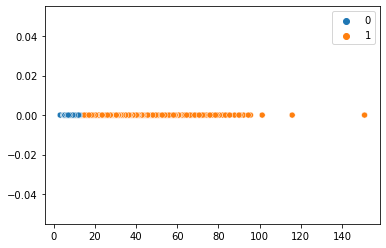

In [66]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)

In [67]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1], dtype=int32), array([1469, 3727]))
              precision    recall  f1-score   support

           0       0.23      0.72      0.35       476
           1       0.96      0.76      0.85      4720

    accuracy                           0.76      5196
   macro avg       0.60      0.74      0.60      5196
weighted avg       0.90      0.76      0.81      5196



## One class SVC

In [203]:
clf = OneClassSVM(gamma='auto', kernel='rbf').fit(np.array(results))

In [204]:
labels = clf.predict(results)
labels = [1 if l == -1 else 0 for l in labels]

<AxesSubplot:>

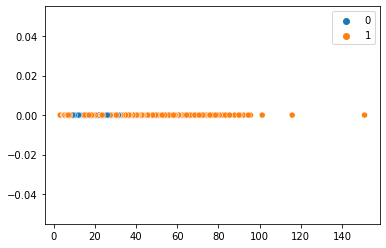

In [205]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)

In [206]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1]), array([2357, 2839]))
              precision    recall  f1-score   support

           0       0.12      0.57      0.19       476
           1       0.93      0.56      0.70      4720

    accuracy                           0.56      5196
   macro avg       0.52      0.57      0.45      5196
weighted avg       0.85      0.56      0.65      5196



In [207]:
roc_auc_score(true_labels, labels)

0.5660019940179462

## LOF


In [78]:
clf = LocalOutlierFactor(n_neighbors=2)
labels = clf.fit_predict(results)

In [79]:
labels = [1 if l == -1 else 0 for l in labels]

<AxesSubplot:>

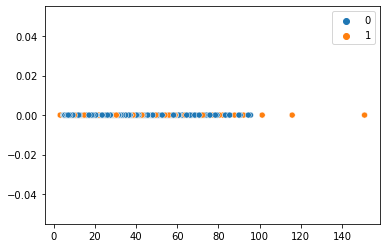

In [80]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)

In [81]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1]), array([4269,  927]))
              precision    recall  f1-score   support

           0       0.09      0.82      0.16       476
           1       0.91      0.18      0.30      4720

    accuracy                           0.24      5196
   macro avg       0.50      0.50      0.23      5196
weighted avg       0.83      0.24      0.29      5196



In [82]:
roc_auc_score(true_labels, labels)

0.49759649622560886

## GMM

In [83]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)

gmm.fit(results)

GaussianMixture(n_components=2)

In [84]:
labels = gmm.predict(results)

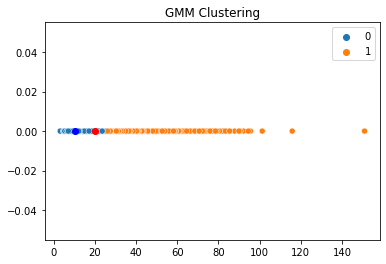

In [85]:
plt.title('GMM Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [86]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1]), array([3633, 1563]))
              precision    recall  f1-score   support

           0       0.13      1.00      0.23       476
           1       1.00      0.33      0.50      4720

    accuracy                           0.39      5196
   macro avg       0.56      0.66      0.36      5196
weighted avg       0.92      0.39      0.47      5196



In [87]:
roc_auc_score(true_labels, labels)

0.663259329155391

## Isolation Forest

In [88]:
from sklearn.ensemble import IsolationForest

ifor = IsolationForest()

pred = ifor.fit_predict(results)

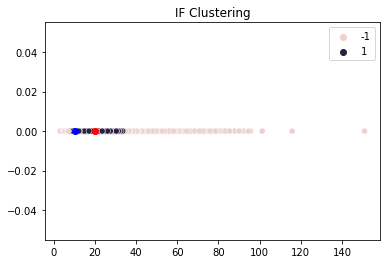

In [89]:
plt.title('IF Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=pred)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [90]:
np.unique(pred, return_counts=True)

(array([-1,  1]), array([1003, 4193]))

In [91]:
labels = [1 if p == -1 else 0 for p in pred]

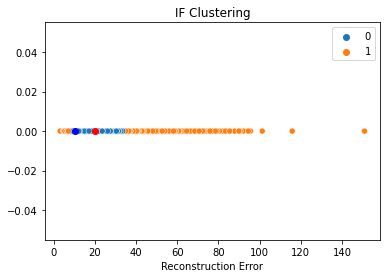

In [92]:
plt.title('IF Clustering')
plt.xlabel('Reconstruction Error')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

<AxesSubplot:title={'center':'IF Clustering'}>

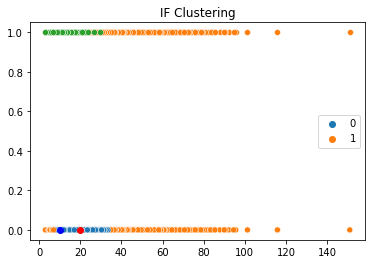

In [93]:
plt.title('IF Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

sns.scatterplot(x=results_anom, y=np.ones(len(results_anom)))
sns.scatterplot(x=results_clean, y=np.ones(len(results_clean)))

In [94]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([ 476, 4720]))
(array([0, 1]), array([4193, 1003]))
              precision    recall  f1-score   support

           0       0.09      0.83      0.17       476
           1       0.92      0.19      0.32      4720

    accuracy                           0.25      5196
   macro avg       0.51      0.51      0.24      5196
weighted avg       0.84      0.25      0.31      5196



In [95]:
roc_auc_score(true_labels, labels)

0.5102727531690642

## DBSCAN

In [100]:
dbscan = DBSCAN()

pred = dbscan.fit_predict(results)

labels = [0 if p >= 0 else 1 for p in pred]

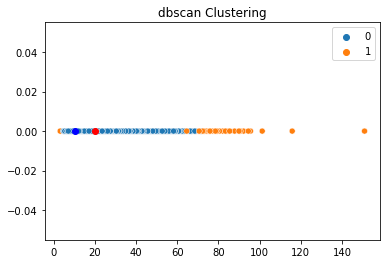

In [102]:
plt.title('dbscan Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [103]:
roc_auc_score(true_labels, labels)

0.5027720410197978

## Redefined Anomalies

In [438]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [14]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [15]:
G, ego_gs, roots = load_bc_data(G)

  0%|          | 0/5196 [00:00<?, ?it/s]

In [16]:
roots = [int(r) for r in roots]

In [17]:
anom_gs, clean_gs = [], []
for idx, root_attr in enumerate(tqdm(roots)):
    if root_attr == 1:
        anom_gs.append(ego_gs[idx])
    else:
        clean_gs.append(ego_gs[idx])
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 298/5196
# of clean graphs: 4898/5196


In [18]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

  0%|          | 0/298 [00:00<?, ?it/s]

In [19]:
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4898 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

In [ ]:
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

In [58]:
# storing results
saved_model = open('rec_error_clean_mod.sav', 'wb')
pickle.dump(results_clean, saved_model)
saved_model.close()

saved_model = open('rec_error_anom_mod.sav', 'wb')
pickle.dump(results_anom, saved_model)
saved_model.close()

In [59]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

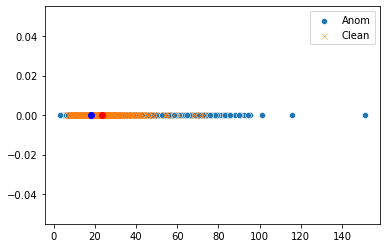

In [60]:
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

plt.legend(['Anom', 'Clean'])

<AxesSubplot:ylabel='Count'>

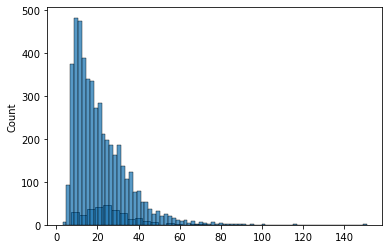

In [61]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d47ef0130>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d47ef0760>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d47ef0c40>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9d47ef0d90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fa16b81e3a0>,
 'means': []}

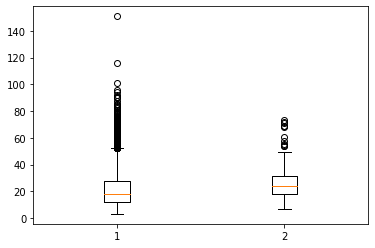

In [62]:
comb = [results_clean, results_anom]
plt.boxplot(comb)

# 2-means clustering

In [181]:
with open('rec_error_clean_mod.sav', 'rb') as f:
    results_clean = pickle.load(f)
    f.close()
    
with open('rec_error_anom_mod.sav', 'rb') as f:
    results_anom = pickle.load(f)
    f.close()

In [182]:
sum(results_anom <= max(results_clean)) / len(results_anom)

1.0

In [141]:
results, true_labels = [], []
results.extend(results_clean); results.extend(results_anom)
true_labels.extend([0] * len(results_clean)); true_labels.extend([1] * len(results_anom))

In [142]:
results = np.array(results).reshape(-1, 1)

In [143]:
kmeans = KMeans(n_clusters=2, random_state=1).fit(results)

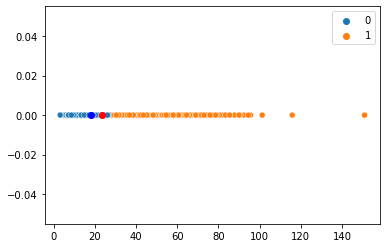

In [144]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=kmeans.labels_)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [145]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(kmeans.labels_, return_counts=True))

print(classification_report(true_labels, kmeans.labels_))

(array([0, 1]), array([4898,  298]))
(array([0, 1], dtype=int32), array([3719, 1477]))
              precision    recall  f1-score   support

           0       0.95      0.72      0.82      4898
           1       0.08      0.39      0.13       298

    accuracy                           0.70      5196
   macro avg       0.52      0.56      0.48      5196
weighted avg       0.90      0.70      0.78      5196



In [146]:
roc_auc_score(true_labels, kmeans.labels_)

0.5574765484336847

## One class K-means

In [147]:
kmeans = KMeans(n_clusters=2).fit(np.array(results_anom).reshape(-1, 1))

In [148]:
labels = kmeans.predict(results)

<AxesSubplot:>

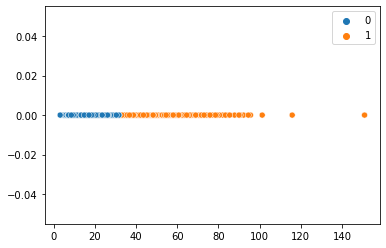

In [149]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)

In [150]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1], dtype=int32), array([4272,  924]))
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      4898
           1       0.07      0.23      0.11       298

    accuracy                           0.79      5196
   macro avg       0.51      0.53      0.50      5196
weighted avg       0.90      0.79      0.84      5196



In [151]:
roc_auc_score(true_labels, labels)

0.5267113545865865

## One class SVC

In [152]:
clf = OneClassSVM(gamma='auto').fit(np.array(results))

In [153]:
labels = clf.predict(results)
labels = [1 if l == -1 else 0 for l in labels]

[-1.12269504e+02 -1.12269504e+02 -1.12269504e+02 ...  6.60606560e-05
  1.92166588e-01  6.18077812e-03]


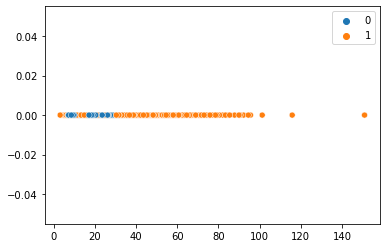

In [154]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
print(clf.decision_function(results))

In [155]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1]), array([2484, 2712]))
              precision    recall  f1-score   support

           0       0.94      0.48      0.63      4898
           1       0.06      0.52      0.10       298

    accuracy                           0.48      5196
   macro avg       0.50      0.50      0.37      5196
weighted avg       0.89      0.48      0.60      5196



In [156]:
roc_auc_score(true_labels, labels)

0.49726227113655486

## LOF

In [157]:
clf = LocalOutlierFactor(n_neighbors=2)
labels = clf.fit_predict(results)
labels = [1 if l == -1 else 0 for l in labels]

<AxesSubplot:>

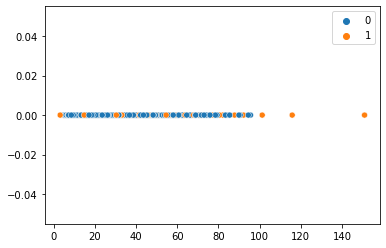

In [158]:
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)

In [159]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1]), array([4269,  927]))
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      4898
           1       0.05      0.15      0.08       298

    accuracy                           0.78      5196
   macro avg       0.50      0.49      0.48      5196
weighted avg       0.89      0.78      0.83      5196



## GMM

In [160]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)

gmm.fit(results)

GaussianMixture(n_components=2)

In [161]:
labels = gmm.predict(results)

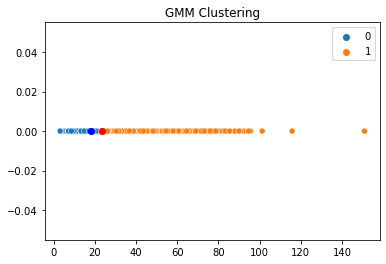

In [162]:
plt.title('GMM Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [163]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1]), array([3651, 1545]))
              precision    recall  f1-score   support

           0       0.95      0.71      0.81      4898
           1       0.08      0.42      0.13       298

    accuracy                           0.69      5196
   macro avg       0.52      0.56      0.47      5196
weighted avg       0.90      0.69      0.77      5196



## Isolation Forest

In [164]:
from sklearn.ensemble import IsolationForest

ifor = IsolationForest()

pred = ifor.fit_predict(results)

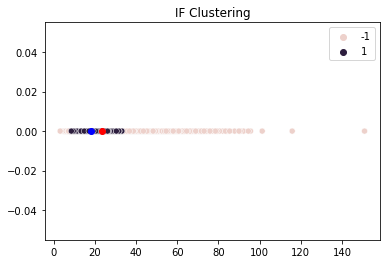

In [165]:
plt.title('IF Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=pred)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

In [166]:
labels = [1 if p == -1 else 0 for p in pred]

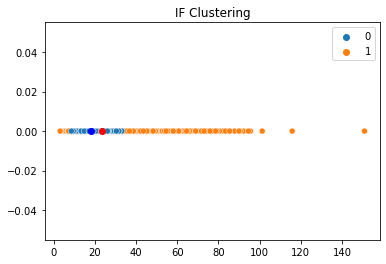

In [167]:
plt.title('IF Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

<AxesSubplot:title={'center':'IF Clustering'}>

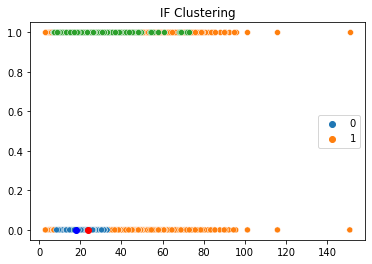

In [168]:
plt.title('IF Clustering')
sns.scatterplot(x=results.flatten(), y=np.zeros(len(results)), hue=labels)
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

sns.scatterplot(x=results_clean, y=np.ones(len(results_clean)))
sns.scatterplot(x=results_anom, y=np.ones(len(results_anom)))

In [169]:
# F1 score

print(np.unique(true_labels, return_counts=True))
print(np.unique(labels, return_counts=True))

print(classification_report(true_labels, labels))

(array([0, 1]), array([4898,  298]))
(array([0, 1]), array([4229,  967]))
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      4898
           1       0.07      0.22      0.10       298

    accuracy                           0.78      5196
   macro avg       0.51      0.52      0.49      5196
weighted avg       0.89      0.78      0.83      5196



In [170]:
roc_auc_score(true_labels, labels)

0.5169820033378917

# Comparing rank

In [2]:
bc_data = scipy.io.loadmat("datasets/blogcatalog.mat")

G = nx.from_scipy_sparse_array(bc_data["Network"])
# nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
print(str(G))

# convert list of lists to list
labels = [j for i in bc_data["Label"] for j in i]

# Add labels to each node
for i in range(len(G.nodes)):
    G.nodes[i]['Anomaly'] = labels[i]

Graph with 5196 nodes and 172897 edges


In [3]:
def load_bc_data(G):

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []
    max_graph = 0

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, max_graph, roots

# get anomalous egonets
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [4]:
G, ego_gs, _, roots = load_bc_data(G)

roots = [int(r) for r in roots]

  0%|          | 0/5196 [00:00<?, ?it/s]

In [36]:
anom_gs, clean_gs = [], []

# anomalous community
for idx, g in enumerate(tqdm(ego_gs, total=len(ego_gs))):
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)

# # anomalous root
# for idx, root_attr in enumerate(tqdm(roots)):
#         if root_attr == 1:
#             anom_gs.append(ego_gs[idx])
#         else:
#             clean_gs.append(ego_gs[idx])

print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [37]:
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)

padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [38]:
with open('bc_decomp_r10.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [39]:
results_anom_rank10 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank10.append(d)
    
results_clean_rank10 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank10.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [40]:
with open('bc_decomp_r20.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [41]:
results_anom_rank20 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank20.append(d)
    
results_clean_rank20 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank20.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [42]:
with open('bc_decomp_r30.sav', 'rb') as f:
    result = pickle.load(f)
    f.close()
    
core, factors = result
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [43]:
results_anom_rank30 = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom_rank30.append(d)
    
results_clean_rank30 = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean_rank30.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [171]:
np.median(results_anom_rank30)

18.804974818125746

Medians (Anom): 
	Rank 10: 23.610176143456272 
	Rank 20: 22.932599428737323 
	Rank 30: 22.412133710017528
Medians (Clean): 
	Rank 10: 17.98302979163246 
	Rank 20: 17.460436164493913 
	Rank 30: 17.024302012599875


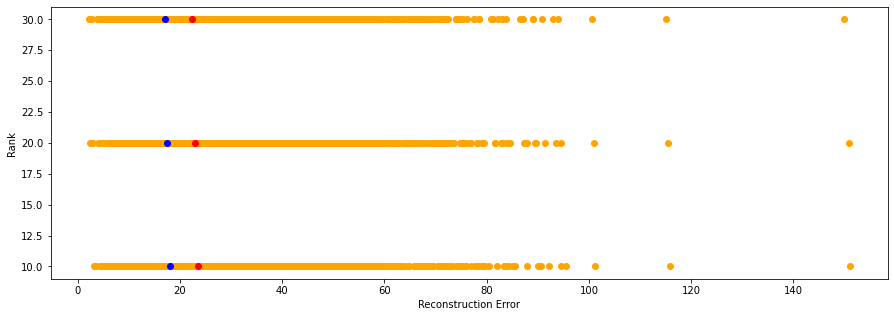

In [139]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
y_len = len(ego_gs)

plt.scatter(x=np.concatenate((results_anom_rank10, results_clean_rank10)), y=np.ones(y_len)*10, c='orange')
plt.scatter([np.median(results_anom_rank10)], 10, c='red')
plt.scatter([np.median(results_clean_rank10)], 10, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank20, results_clean_rank20)), y=np.ones(y_len)*20, c='orange')
plt.scatter([np.median(results_anom_rank20)], 20, c='red')
plt.scatter([np.median(results_clean_rank20)], 20, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank30, results_clean_rank30)), y=np.ones(y_len)*30, c='orange')
plt.scatter([np.median(results_anom_rank30)], 30, c='red')
plt.scatter([np.median(results_clean_rank30)], 30, c='blue')

# plt.legend(['Anom', 'Clean'])

plt.ylabel('Rank')
plt.xlabel('Reconstruction Error')

print("Medians (Anom):", '\n\tRank 10:', np.median(results_anom_rank10), '\n\tRank 20:', np.median(results_anom_rank20), '\n\tRank 30:', np.median(results_anom_rank30))
print("Medians (Clean):", '\n\tRank 10:', np.median(results_clean_rank10), '\n\tRank 20:', np.median(results_clean_rank20), '\n\tRank 30:', np.median(results_clean_rank30))

Means (Anom): 
	Rank 10: 25.714925869115064 
	Rank 20: 25.11353289476427 
	Rank 30: 24.49853495107652
Means (Clean): 
	Rank 10: 21.478109695233666 
	Rank 20: 20.95061081256904 
	Rank 30: 20.42506062796625


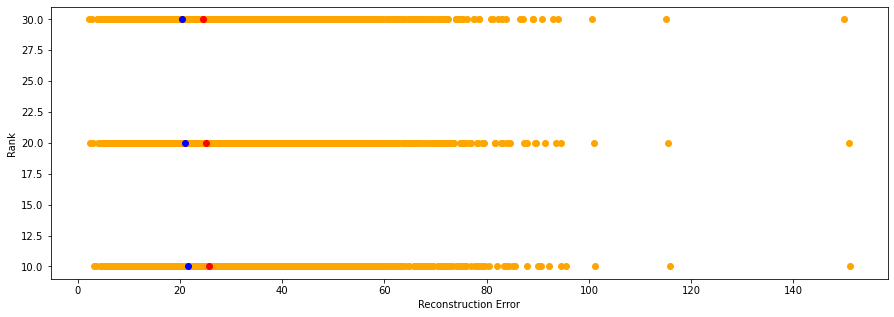

In [140]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
y_len = len(ego_gs)

plt.scatter(x=np.concatenate((results_anom_rank10, results_clean_rank10)), y=np.ones(y_len)*10, c='orange')
plt.scatter([np.mean(results_anom_rank10)], 10, c='red')
plt.scatter([np.mean(results_clean_rank10)], 10, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank20, results_clean_rank20)), y=np.ones(y_len)*20, c='orange')
plt.scatter([np.mean(results_anom_rank20)], 20, c='red')
plt.scatter([np.mean(results_clean_rank20)], 20, c='blue')

plt.scatter(x=np.concatenate((results_anom_rank30, results_clean_rank30)), y=np.ones(y_len)*30, c='orange')
plt.scatter([np.mean(results_anom_rank30)], 30, c='red')
plt.scatter([np.mean(results_clean_rank30)], 30, c='blue')

# plt.legend(['Anom', 'Clean'])

plt.ylabel('Rank')
plt.xlabel('Reconstruction Error')

print("Means (Anom):", '\n\tRank 10:', np.mean(results_anom_rank10), '\n\tRank 20:', np.mean(results_anom_rank20), '\n\tRank 30:', np.mean(results_anom_rank30))
print("Means (Clean):", '\n\tRank 10:', np.mean(results_clean_rank10), '\n\tRank 20:', np.mean(results_clean_rank20), '\n\tRank 30:', np.mean(results_clean_rank30))

## PCA

In [14]:
from sklearn.manifold import TSNE

In [44]:
results = np.array([results_anom_rank10 + results_clean_rank10, results_anom_rank20 + results_clean_rank20, results_anom_rank30 + results_clean_rank30])
X_emb = TSNE(init='pca', n_components=2).fit_transform(results.T)

/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [45]:
labels = []
labels += [1] * len(results_anom_rank10) + [0] * len(results_clean_rank10)

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

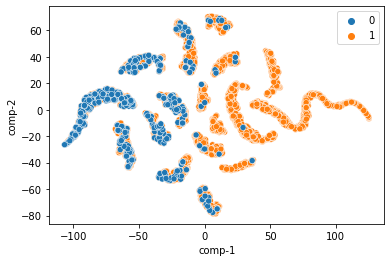

In [46]:
df = pd.DataFrame()
df["y"] = labels
df["comp-1"] = X_emb[:,0]
df["comp-2"] = X_emb[:,1]


sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df)

In [47]:
labels = []
labels += [1] * len(results_anom_rank10) + [0] * len(results_clean_rank10)

<AxesSubplot:>

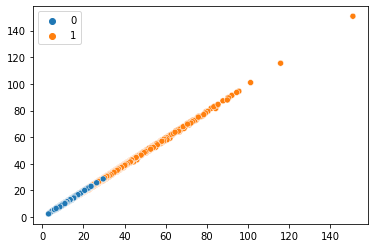

In [48]:
sns.scatterplot(x=results[0], y=results[1], hue=labels)

In [53]:
pred = [0 if err < 20 else 1 for err in results[0]]

In [54]:
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.16      0.97      0.28       476
           1       0.99      0.49      0.66      4720

    accuracy                           0.54      5196
   macro avg       0.58      0.73      0.47      5196
weighted avg       0.92      0.54      0.62      5196



# Testing on different data

In [215]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)

    return G, ego_gs, roots

In [99]:
G, ego_gs, roots = load_network('datasets/Flickr.mat')

roots = [int(r) for r in roots]

Graph with 7575 nodes and 241482 edges


  0%|          | 0/7575 [00:00<?, ?it/s]

In [100]:
print(f'Using {len(ego_gs)} egonets')

Using 7575 egonets


In [101]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [102]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs)):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/7575 [00:00<?, ?it/s]

# of anomalous graphs: 5243/7575
# of clean graphs: 2332/7575


In [105]:
slice_size = int(input("Input a slice size for tensor: "))

Input a slice size for tensor: 1000


In [6]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_clean.append(padded)

NameError: name 'anom_gs' is not defined

# CP Decomposition

In [212]:
with open('bc_cpd_r50.sav', 'rb') as f:
    factors = pickle.load(f)
    f.close()
    
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [213]:
# get anomalous egonets for definition 2
def is_anomolous(G):
    for node in G.nodes():
        if G.nodes[node]['Anomaly'] == 1:
            return True
    return False

In [216]:
G, ego_gs, roots = load_network('datasets/Blogcatalog.mat')

roots = [int(r) for r in roots]

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

In [217]:
anom_gs, clean_gs = [], []
for idx, g in enumerate(tqdm(ego_gs)):
    # check if root is anomolous first
    if is_anomolous(g):
        anom_gs.append(g)
    else:
        clean_gs.append(g)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [218]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((1000, 1000))
    padded[:g.shape[0], :g.shape[1]] = g
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [219]:
results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((pinv(A) @ gs) @ B) @ pinv(B))
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)
    
results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((pinv(A) @ gs) @ B) @ pinv(B))
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [24]:
anom_y = np.zeros(len(results_anom))
clean_y = np.zeros(len(results_clean))

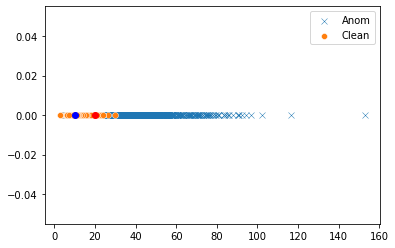

In [26]:
sns.scatterplot(x=results_anom, y=anom_y, marker='x')
sns.scatterplot(x=results_clean, y=clean_y, marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 0, c='blue')

plt.legend(['Anom', 'Clean'])